In [1]:
import sys
sys.path.append('../')
import os

In [2]:
BASE_DIR = '../data/historical_klines/'

### ライブラリのインストール

In [54]:
import pandas as pd
import numpy as np
from datetime import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import joblib

### データの読み込み
＊データはダウンロードしておく必要がある

In [21]:
#パラメータの指定

symbols = [
    'ADA',
    'ASTR',
    'ATOM',
    'BAT',
    'BCH',
    'DAI',
    'DOT',
    'ENJ',
    'ETH',
    'FCR',
    'LINK',
    'LTC',
    'MKR',
    'MONA',
    'OMG',
    'QTUM',
    'XEM',
    'XLM',
    'XRP',
    'XTZ',
]
    
interval = '5min'

train_str_date = pd.to_datetime(datetime(2023,6,20))#.strftime('%Y%m%d')
train_end_date = pd.to_datetime(datetime(2023,6,30))#.strftime('%Y%m%d')

valid_str_date = pd.to_datetime(datetime(2023,7,1)).strftime('%Y%m%d')
valid_end_date = pd.to_datetime(datetime(2023,7,9)).strftime('%Y%m%d')

In [5]:
df = pd.DataFrame()

for symbol in symbols:
    for date in pd.date_range(start=train_str_date, end=valid_end_date):
        try:
            temp_df = pd.read_csv(f'{BASE_DIR}{interval}/{symbol}/{symbol}_{interval}_{date.strftime("%Y%m%d")}.csv')
            temp_df['symbol'] = symbol  # Add a new column to store symbol name
            df = pd.concat([df, temp_df], axis=0)
        except FileNotFoundError:
            print(f'File {BASE_DIR}{interval}/{symbol}/{symbol}_{interval}_{date.strftime("%Y%m%d")}.csv not found. Skipping...')


# Assuming df is your dataframe and 'openTime' is your column with the date
df['openTime'] = pd.to_datetime(df['openTime'], unit='ms')  # convert from UNIX timestamp, if necessary
df["datetime_f"] = df['openTime'] 
df["symbol_f"] = df['symbol']
# Convert 'symbol' and 'openTime' columns to index, creating a MultiIndex
df.set_index(['openTime', 'symbol'], inplace=True)


In [6]:
df

,,open,high,low,close,volume,datetime_f,symbol_f
openTime,symbol,,,,,,,
2023-06-19 21:05:00,ADA,37.340,37.340,37.340,37.340,100.0,2023-06-19 21:05:00,ADA
2023-06-19 21:15:00,ADA,37.339,37.339,37.339,37.339,20.0,2023-06-19 21:15:00,ADA
2023-06-19 22:20:00,ADA,37.202,37.202,37.202,37.202,200.0,2023-06-19 22:20:00,ADA
2023-06-19 22:35:00,ADA,37.311,37.311,37.311,37.311,3300.0,2023-06-19 22:35:00,ADA
2023-06-19 22:45:00,ADA,37.400,37.426,37.400,37.426,35.0,2023-06-19 22:45:00,ADA
...,...,...,...,...,...,...,...,...
2023-07-09 16:45:00,XTZ,116.718,116.718,116.718,116.718,0.4,2023-07-09 16:45:00,XTZ
2023-07-09 16:50:00,XTZ,116.010,116.010,116.010,116.010,55.0,2023-07-09 16:50:00,XTZ
2023-07-09 17:55:00,XTZ,116.670,116.670,116.670,116.670,0.5,2023-07-09 17:55:00,XTZ


In [7]:
train_df = df[(df.index.get_level_values('openTime') >= train_str_date) & (df.index.get_level_values('openTime') <= train_end_date)]
valid_df = df[(df.index.get_level_values('openTime') >= valid_str_date) & (df.index.get_level_values('openTime') <= valid_end_date)]

### テクニカル特徴量

In [8]:
def cal_technical_f(df):
    df = df.copy()
    #移動平均からの乖離率
    for i in [5, 20]:
        df[f"{i}sma_d_rate"] = df.groupby("symbol")["close"].transform(lambda x: x/(x.rolling(i).mean()) - 1)
    #直近のリターン
    df["past_1return"] = df.groupby("symbol")["close"].transform(lambda x: x/x.shift(1) - 1)
    #高値と安値の差額を終値で除した値
    df["h_l_by_c"] = (df["high"] - df["low"])/df["close"]
    #始値と終値の差を終値で除した値
    df["c_o_by_c"] = (df["close"] - df["open"])/df["close"]
    return df

### カテゴリ変数

In [9]:
def cal_category_f(df):
    df = df.copy()
    #日付情報を分割
    df["month"] = df["datetime_f"].dt.month
    df["day"] = df["datetime_f"].dt.day
    df["hour"] = df["datetime_f"].dt.hour
    df["week"] = df["datetime_f"].dt.dayofweek #曜日
    return df

### ターゲット

In [10]:
def cal_target(df):
    df.loc[:, "return"] = df.groupby("symbol")["close"].transform(lambda x: x.shift(-1)/x - 1)
    df.loc[:, "return_rank"] = df.groupby("openTime")["return"].transform(lambda x: x.rank(method = "min"))
    return df

### 分割したDataFrameごとに計算

In [11]:
train_df = cal_technical_f(train_df)
train_df = cal_category_f(train_df)
train_df = cal_target(train_df)

valid_df = cal_technical_f(valid_df)
valid_df = cal_category_f(valid_df)
valid_df = cal_target(valid_df)

### 特徴量とターゲットの指定

In [12]:
f_list = [
    #"open",
    #"close",
    #"high",
    #"low",
    "volume", #注文現物通貨量
    #"q_volume", #注文引用通貨量
    #"n_trades",
    #"taker_vol", #成行注文現物通貨量
    #"taker_q_vol", #成行注文引用通貨量
    #テクニカル特徴量
    "5sma_d_rate",
    "20sma_d_rate",
    #"75sma_d_rate",
    #"200sma_d_rate",
    "past_1return",
    "h_l_by_c",
    "c_o_by_c",
    #"taker_r",
    #"taker_q_r", 
    #"vol_by_trade",
    #カテゴリ変数
    "symbol_f",
    #"month",
    #"day",
    "hour",
    #"week",
]

target = "return_rank"

### ラベルエンコーディング

In [13]:
le = LabelEncoder()
train_df['symbol_f'] = le.fit_transform(train_df['symbol_f'])
valid_df['symbol_f'] = le.fit_transform(valid_df['symbol_f'])

### 学習

In [55]:
class LambdaRank_all:
    def __init__(self, df_train, df_valid, df_test, symbols_num, f_list, target):
        self.df_train = df_train
        self.df_valid = df_valid
        self.df_test = df_test
        self.symbols_num = symbols_num
        self.f_list = f_list
        self.target = target
    
    def train(self):
        ranker = lgb.LGBMRanker(
            n_estimators=500,
            learning_rate=0.05,
            objective="lambdarank",
            label_gain=np.arange(200),
            # lambdarank_truncation_level=max_labels,
            # max_depth=5,
            # colsample_bytree=0.5,
            # num_leaves=2**6-1,
            n_jobs=-1
        )

        ranker.fit(
            X = self.df_train[self.f_list],
            y = self.df_train[self.target],
            group = self.df_train.groupby("datetime_f")["datetime_f"].count().to_numpy(),
            eval_set = [(self.df_valid[self.f_list], self.df_valid[self.target])],
            eval_group = [self.df_valid.groupby("datetime_f")["datetime_f"].count().to_numpy()],
        )

        lgb.plot_importance(ranker, figsize = (12,8))

        #学習済みモデルの保存
        joblib.dump(ranker, './ranker_model.pkl') 

        self.df_train.loc[:,"predict_value"] = ranker.predict(self.df_train[self.f_list]).copy()
        self.df_valid.loc[:,"predict_value"] = ranker.predict(self.df_valid[self.f_list]).copy()
        self.df_test.loc[:,"predict_value"] = ranker.predict(self.df_test[self.f_list]).copy()

        self.df_train["predict_rank"] = self.df_train.groupby("openTime")["predict_value"].transform(lambda x: x.rank(method = "min"))
        self.df_train.reset_index(level = "symbol").groupby("predict_rank")["return"].mean()

        self.df_valid["predict_rank"] = self.df_valid.groupby("openTime")["predict_value"].transform(lambda x: x.rank(method = "min"))
        self.df_valid.reset_index(level = "symbol").groupby("predict_rank")["return"].mean()

        self.df_test["predict_rank"] = self.df_test.groupby("openTime")["predict_value"].transform(lambda x: x.rank(method = "min"))
        self.df_test.reset_index(level = "symbol").groupby("predict_rank")["return"].mean()




    def result(self, save_dir):


        df_short = self.df_train.loc[self.df_train["predict_rank"] <= int(self.symbols_num*0.5)].groupby(level = "openTime")["return"].mean().cumsum()
        df_long = self.df_train.loc[self.df_train["predict_rank"] > int(self.symbols_num*0.5)].groupby(level = "openTime")["return"].mean().cumsum()
        df_ls_train = df_long - df_short

        df_short = self.df_valid.loc[self.df_valid["predict_rank"] <= int(self.symbols_num*0.5)].groupby(level = "openTime")["return"].mean().cumsum()
        df_long = self.df_valid.loc[self.df_valid["predict_rank"] > int(self.symbols_num*0.5)].groupby(level = "openTime")["return"].mean().cumsum()
        df_ls_valid = df_long - df_short

        df_short = self.df_test.loc[self.df_test["predict_rank"] <= int(self.symbols_num*0.5)].groupby(level = "openTime")["return"].mean().cumsum()
        df_long = self.df_test.loc[self.df_test["predict_rank"] > int(self.symbols_num*0.5)].groupby(level = "openTime")["return"].mean().cumsum()
        df_ls_test = df_long - df_short

        # 時系列グラフを作成

        fig = plt.figure(figsize = (20,7))

        ax1 = fig.add_subplot(4, 1, 1)
        ax2 = fig.add_subplot(4, 1, 2)
        ax3 = fig.add_subplot(4, 1, 3)
        ax4 = fig.add_subplot(4, 1, 4)


        ax1.plot(pd.to_datetime(list(df_ls_train.index)), df_ls_train, label = "train")
        ax1.legend()
        ax1.set_xlabel('Date')
        ax1.set_ylabel('cumsum return')

        ax2.plot(pd.to_datetime(list(df_ls_valid.index)), df_ls_valid, label = "valid")
        ax2.legend()
        ax2.set_xlabel('Date')
        ax2.set_ylabel('cumsum return')

        ax3.plot(pd.to_datetime(list(df_ls_test.index)), df_ls_test, label = "test")
        ax3.legend()
        ax3.set_xlabel('Date')
        ax3.set_ylabel('cumsum return')

        ax4.text(0.05, 0.5, list(self.f_list))


        plt.savefig(save_dir) 
        plt.show()

[1]	valid_0's ndcg@1: 0.660245	valid_0's ndcg@2: 0.701705	valid_0's ndcg@3: 0.742603	valid_0's ndcg@4: 0.774678	valid_0's ndcg@5: 0.804365
[2]	valid_0's ndcg@1: 0.666259	valid_0's ndcg@2: 0.709922	valid_0's ndcg@3: 0.74472	valid_0's ndcg@4: 0.779166	valid_0's ndcg@5: 0.808944
[3]	valid_0's ndcg@1: 0.674168	valid_0's ndcg@2: 0.713929	valid_0's ndcg@3: 0.749275	valid_0's ndcg@4: 0.782216	valid_0's ndcg@5: 0.811992
[4]	valid_0's ndcg@1: 0.675865	valid_0's ndcg@2: 0.713233	valid_0's ndcg@3: 0.749767	valid_0's ndcg@4: 0.78232	valid_0's ndcg@5: 0.812253
[5]	valid_0's ndcg@1: 0.674725	valid_0's ndcg@2: 0.713966	valid_0's ndcg@3: 0.750226	valid_0's ndcg@4: 0.782205	valid_0's ndcg@5: 0.81284
[6]	valid_0's ndcg@1: 0.675897	valid_0's ndcg@2: 0.713772	valid_0's ndcg@3: 0.749974	valid_0's ndcg@4: 0.782373	valid_0's ndcg@5: 0.812951
[7]	valid_0's ndcg@1: 0.675881	valid_0's ndcg@2: 0.71451	valid_0's ndcg@3: 0.750211	valid_0's ndcg@4: 0.782178	valid_0's ndcg@5: 0.812834
[8]	valid_0's ndcg@1: 0.678769	

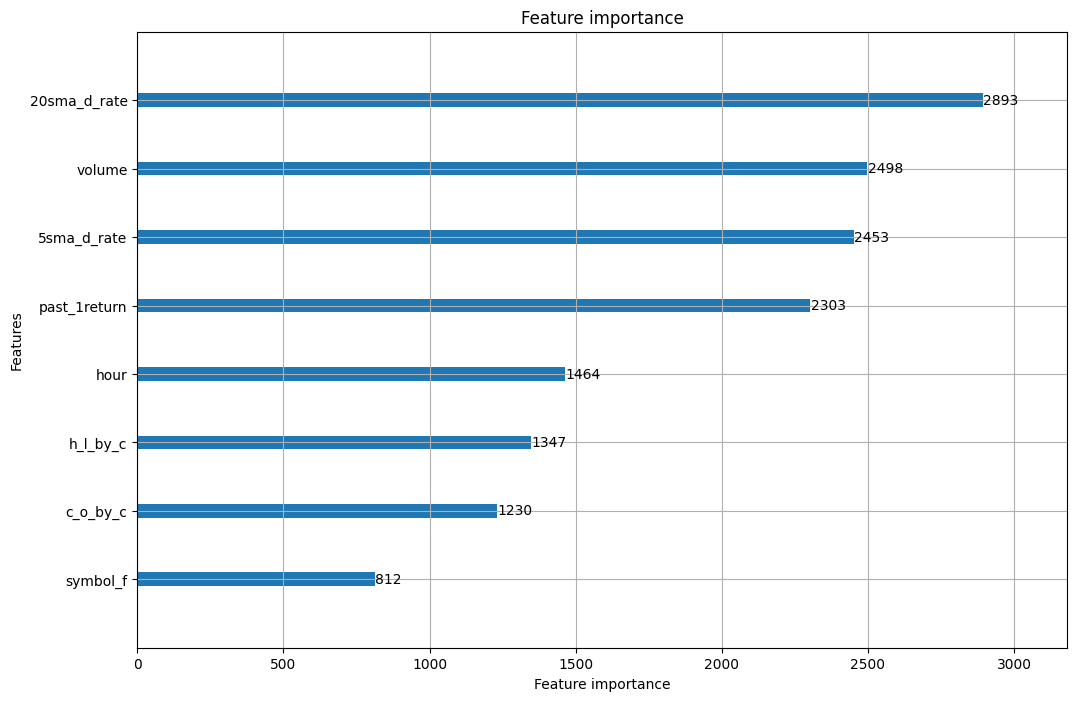

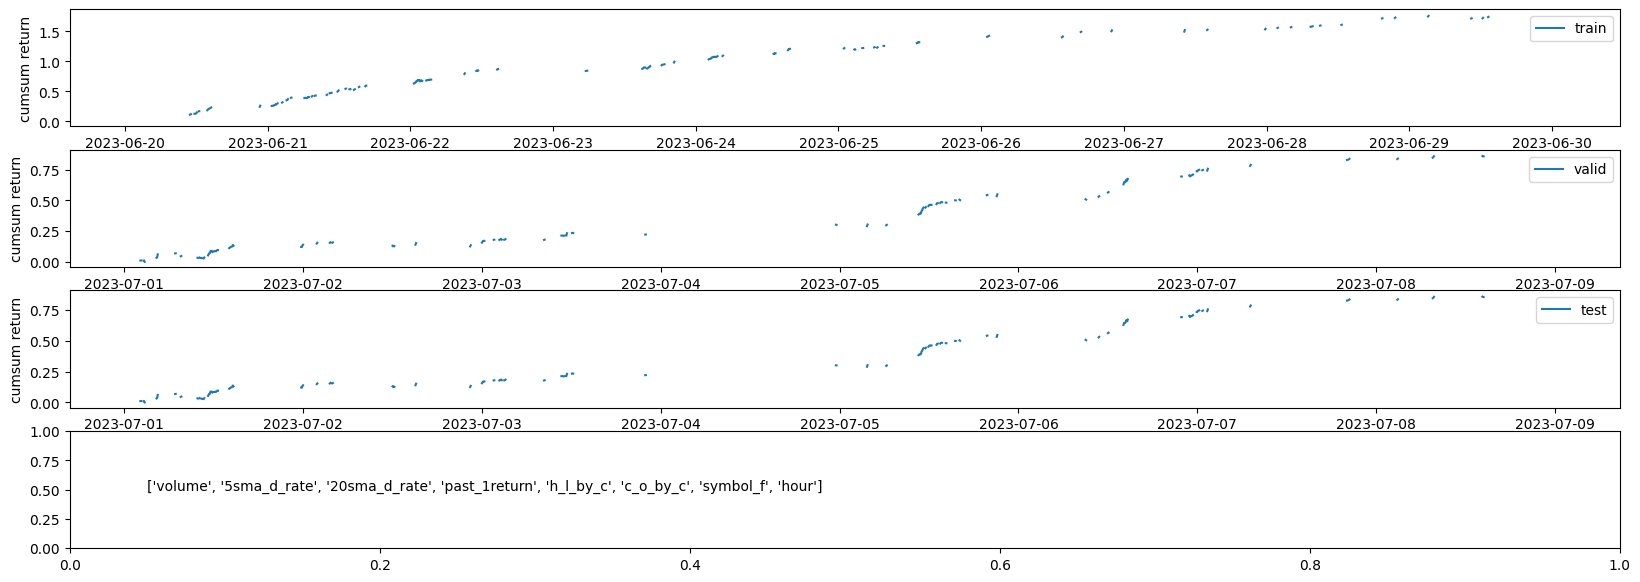

In [56]:
LTR_model = LambdaRank_all(train_df, valid_df, valid_df, len(symbols), f_list, target)
LTR_model.train()
LTR_model.result("./")

In [16]:
result = LTR_model.df_valid

*** データ数が十分にない場合，result["predict_rank"] > int(len(symbols)*0.3)　この条件を満たす銘柄が存在しない可能性がある

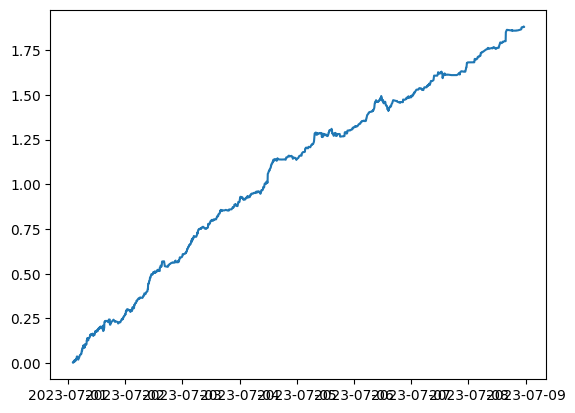

In [17]:
plt.plot(result.loc[result["predict_rank"] > int(len(symbols)*0.3)].groupby(level = "openTime")["return"].mean().cumsum())

In [18]:
result.loc[result["predict_rank"] > int(len(symbols)*0.3)].groupby(level = "openTime")["return"]

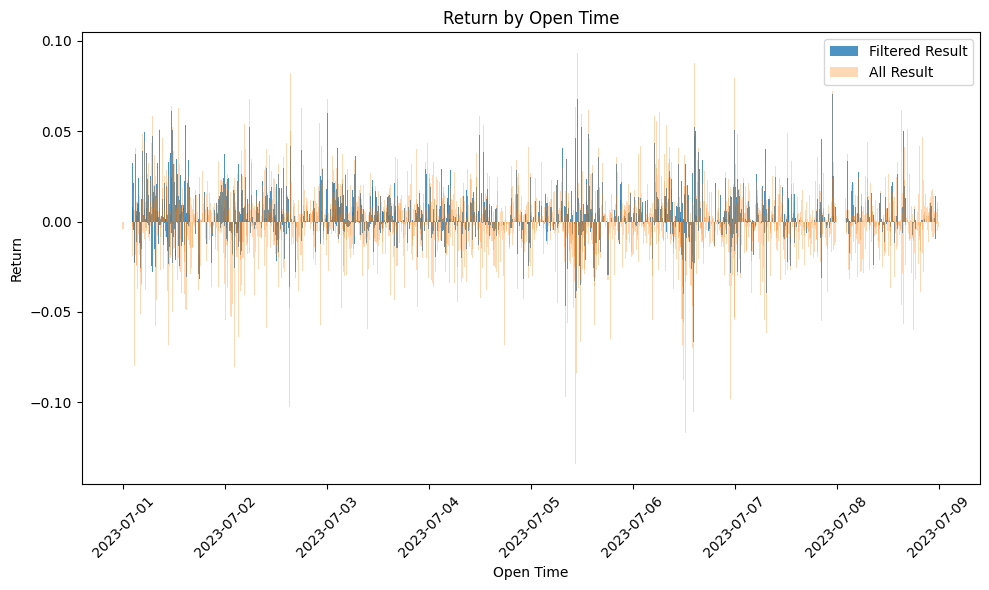

In [46]:
# Plot the bar chart with narrower bars
filtered_result = result.loc[result["predict_rank"] > int(len(symbols)*0.3)].groupby(level = "openTime")["return"].sum()
all_result = result.groupby(level = "openTime")["return"].sum()
# Plot the bar chart with narrower bars and transparency
plt.figure(figsize=(10, 6))
plt.bar(filtered_result.index, filtered_result.values, width=0.01, label='Filtered Result', alpha=0.8)  # Add transparency with `alpha`
plt.bar(all_result.index, all_result.values, width=0.01, label='All Result', alpha=0.3)  # Add transparency with `alpha`
plt.xlabel('Open Time')
plt.ylabel('Return')
plt.title('Return by Open Time')
plt.xticks(rotation=45)
plt.legend()  # Add a legend to distinguish the bars
plt.tight_layout()
plt.show()

Filtered Result Statistics:
 count    1193.000000
mean        0.003908
std         0.013787
min        -0.066846
25%        -0.001744
50%         0.001773
75%         0.009454
max         0.070407
Name: return, dtype: float64

All Result Statistics:
 count    2245.000000
mean       -0.000171
std         0.019282
min        -0.133956
25%        -0.008586
50%         0.000248
75%         0.008796
max         0.093314
Name: return, dtype: float64


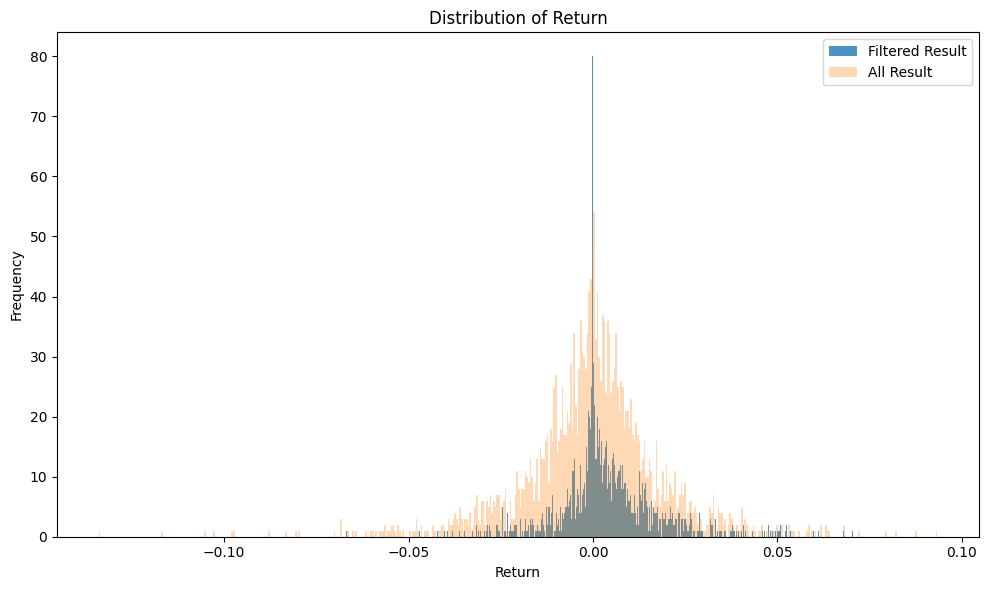

In [52]:
# Compute descriptive statistics for filtered_result and all_result
filtered_result_stats = filtered_result.describe()
all_result_stats = all_result.describe()

# Print descriptive statistics
print('Filtered Result Statistics:\n', filtered_result_stats)
print('\nAll Result Statistics:\n', all_result_stats)

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(filtered_result, bins=500, alpha=0.8, label='Filtered Result')  # Create a histogram
plt.hist(all_result, bins=500, alpha=0.3, label='All Result')  # Create a histogram
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Distribution of Return')
plt.legend()  # Add a legend
plt.tight_layout()
plt.show()
